
## Business and Data Understanding
* Most telecom companies suffer from voluntary churn. Churn rate has strong impact on the life time value of the customer because it affects the length of service and the future revenue of the company. <br>
* When a customer leaves, the company loses money spent on acquiring the customer and also future revenue that could have been generated from that customer. It also could destroy the brand image of the company<br>
* Using the data provided,I will create a model to identify customer churn behaviour from observations, with my main goal being high precision and accuracy 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score,plot_confusion_matrix,auc,roc_curve
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('tel_data.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


#### baseline model

In [3]:
# get predictors and the target

X = data.drop(['churn','phone number'], axis=1)
y = data['churn'].astype('int')


In [4]:
# numeric and categorical columns

cat_cols = ['state','area code','international plan','voice mail plan']
numeric_cols = list(X.drop(columns = cat_cols, axis=1).columns)

In [5]:
# for standardizing numerical columns
num_pipeline = Pipeline(steps=[('scale',MinMaxScaler())])

# for encoding categorical variables
cat_pipeline = Pipeline(steps=[('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [6]:
# combining the pipelines above

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,numeric_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)],
    remainder='drop',
    n_jobs=-1)

In [7]:
# creating the main pipeline

pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', LogisticRegression(solver='liblinear'))
])

In [8]:
# splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)  

In [9]:
#fitting the data

pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
                                                   'total night charge',
                                                   'total intl minutes',
                                                   'total intl calls',
                                                   'total intl charge',
                                                   'customer service calls']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('model', LogisticRegression(solver='liblinear'))])

In [10]:
# checking the metrics

y_prediction = pipeline.predict(X_test)
print('accuracy', pipeline.score(X_test, y_test))
print('precision', precision_score(y_test,y_prediction))
print('recall', recall_score(y_test,y_prediction))

accuracy 0.8530734632683659
precision 0.5454545454545454
recall 0.1782178217821782


* The accuracy is high. This is an unbalanced data set, so a model that predicts the majority class will ofcourse show high accuracy.
But my main focus will be on precision, so I will look for a model that has good precision. Thankfully, the precision seems to be higher than the recall even in this model

#### Creating new dataframes with the transformed data

In [11]:
# transform X_train

train_transformed = col_trans.fit_transform(X_train) 

In [12]:
# get the transformed categorical columns

train_transformed_columns = pipeline.named_steps['col_trans'].named_transformers_['cat_pipeline'].\
                            named_steps['one-hot'].get_feature_names_out(cat_cols)

In [13]:
# combine the categorical columns with the numeric columns

all_cols = np.concatenate([numeric_cols, train_transformed_columns])

In [14]:
#create dataframe of the new X_train

new_X_train = pd.DataFrame(train_transformed, columns = all_cols)
print(new_X_train.shape)
new_X_train.head()

(2666, 73)


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,1.000000,0.0,0.266801,0.459259,0.266892,0.450096,0.370588,0.450016,0.648198,0.598592,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.442149,0.0,0.314187,0.555556,0.314189,0.532582,0.647059,0.532514,0.499462,0.422535,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.305785,0.0,0.631246,0.355556,0.631250,0.899093,0.652941,0.899385,0.497041,0.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.578512,0.0,0.356979,0.503704,0.356926,0.494913,0.364706,0.494985,0.316299,0.669014,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.351240,0.0,0.613728,0.488889,0.613682,0.732197,0.452941,0.732449,0.513179,0.542254,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [15]:
#transform X_test

test_transformed = col_trans.transform(X_test) 

In [16]:
#create dataframe of new X_test

new_X_test= pd.DataFrame(test_transformed, columns = all_cols)
print(new_X_test.shape)
new_X_test.head()

(667, 73)


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,0.462810,0.0,0.437679,0.466667,0.437669,0.908991,0.623529,0.909091,0.447015,0.633803,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.272727,0.0,0.305859,0.644444,0.305912,0.597745,0.729412,0.597865,0.444325,0.760563,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.400826,0.0,-0.007467,-0.222222,-0.007432,0.438823,0.764706,0.439016,0.387036,0.387324,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.603306,0.0,0.603676,0.362963,0.603716,0.561177,0.535294,0.561307,0.357719,0.563380,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.392562,0.0,0.406088,0.533333,0.406081,0.617817,0.429412,0.617923,0.550027,0.408451,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [17]:
#balancing the dataset

X_train_balanced, y_train_balanced = SMOTE(random_state=42).fit_resample(new_X_train,y_train)

#### First model-  Logistic Model and balanced data

In [18]:
logmodel = LogisticRegression(max_iter=1000,solver='liblinear')

grid={"C":[1e12,1e6,10000,1000,10, 1, .1, .001], "penalty":['l2','l1']}

lg_grid1 = GridSearchCV(estimator=logmodel, 
                          param_grid=grid, 
                          cv=10)

In [19]:
#fitting the model

lg_grid1.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [1000000000000.0, 1000000.0, 10000, 1000, 10, 1,
                               0.1, 0.001],
                         'penalty': ['l2', 'l1']})

In [20]:
#predicting
y_pred1 = lg_grid1.predict(new_X_test)

In [21]:
#metrics
print('accuracy', lg_grid1.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred1))
print('recall', recall_score(y_test,y_pred1))

accuracy 0.7856071964017991
precision 0.395
recall 0.7821782178217822


* Precision dropped, so not the model am going for

#### Second model- Decision trees

In [22]:
# Default Decision tree with balanced and unbalanced dataset

* Accuracy high,from both being an imbalanced data and probably from overfitting too.Precision and recall high too

In [23]:
#balanced data

clf1 = DecisionTreeClassifier(random_state=42)
clf1.fit(X_train_balanced,y_train_balanced)
y_pred4 = clf1.predict(new_X_test)

#metrics
print('accuracy', clf1.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred4))
print('recall', recall_score(y_test,y_pred4))

accuracy 0.8845577211394303
precision 0.5923076923076923
recall 0.7623762376237624


* Accuracy went down.The data is now balanced and that could be a reason the accuracy decreased.Precision dropped so not the model I want

#### using different hyperparameters of decision tree classifier with balanced data set

In [24]:

classifier = DecisionTreeClassifier(random_state=42)

grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5],
    'min_samples_leaf': [1, 5, 10, 15]
}


dt_cv = GridSearchCV(estimator=classifier, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)


In [25]:
dt_cv.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5],
                         'min_samples_leaf': [1, 5, 10, 15]},
             scoring='accuracy')

In [26]:
y_pred5 = dt_cv.predict(new_X_test)

In [27]:
print('accuracy', dt_cv.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred5))
print('recall', recall_score(y_test,y_pred5))

accuracy 0.9145427286356822
precision 0.7037037037037037
recall 0.7524752475247525


In [28]:
dt_cv.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}

* Good accuracy, precision increased than the classifier above. But still quite low

### Third model- random forest

In [29]:
# Random Forest classifier- unbalanced data
rf = RandomForestClassifier(random_state=42)
rf.fit(new_X_train,y_train)
#predict
y_pred6 = rf.predict(new_X_test)

#metrics
print('accuracy', rf.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred6))
print('recall', recall_score(y_test,y_pred6))

accuracy 0.9415292353823088
precision 0.9696969696969697
recall 0.6336633663366337


* Very good accuracy and precision, but this is unbalanced data

In [30]:
# Random Forest classifier- balanced data

rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_train_balanced,y_train_balanced)
y_pred7 = rf1.predict(new_X_test)

print('accuracy', rf1.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred7))
print('recall', recall_score(y_test,y_pred7))

accuracy 0.9310344827586207
precision 0.7777777777777778
recall 0.7623762376237624


* Increased accuracy and precision on this random forest classifier with default parameters

In [31]:
#random forest with different hyperparameters and balanced data

In [36]:
rf2 = RandomForestClassifier(random_state=42)
#hyperparameters
param_grid = { 
    'n_estimators': [50, 100,150],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [37]:
CV_rf = GridSearchCV(estimator=rf2, param_grid=param_grid, cv= 10)
CV_rf.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]})

In [38]:
y_pred8 = CV_rf.predict(new_X_test)

print('accuracy', CV_rf.score(new_X_test, y_test))
print('precision', precision_score(y_test,y_pred8))
print('recall', recall_score(y_test,y_pred8))

accuracy 0.9115442278860569
precision 0.6810344827586207
recall 0.7821782178217822


### Forth Model- xgbclasssifier


In [39]:
from xgboost import XGBClassifier
estimator = XGBClassifier(
    objective = 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 6, 1),
    'n_estimators': range(60, 220, 60),
    'learning_rate': [0.01, 0.1, 0.2, 0.4]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs =-1,
    cv = 10,
    verbose=True
)


In [40]:

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.4],
                         'max_depth': range(2, 6),
                         'n_estimators': range(60, 220, 60)},
             scoring='roc_auc', verbose=True)

In [41]:
#prediction and metrics
y_pred9 = grid_search.predict(new_X_test)

print('accuracy', grid_search.score(new_X_test, y_test)) 
print('precision', precision_score(y_test,y_pred9)) 
print('recall', recall_score(y_test,y_pred9)) 

accuracy 0.9313752930063324
precision 0.9010989010989011
recall 0.8118811881188119


In [42]:
grid_search.best_params_ 

{'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 180}

### Final Chosen model

In [43]:
xgb = XGBClassifier(objective = 'binary:logistic',nthread=4,seed=42,
                    max_depth= 5, n_estimators = 180,
                    learning_rate = 0.4)
xgb.fit(X_train_balanced, y_train_balanced)  


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)

In [44]:
#prediction and metrics
predictions = xgb.predict(new_X_test)

print('accuracy', xgb.score(new_X_test, y_test))
print('precision', precision_score(y_test,predictions))
print('recall', recall_score(y_test,predictions))

accuracy 0.9580209895052474
precision 0.9010989010989011
recall 0.8118811881188119


In [45]:
#Calculating the AUC

y_score = xgb.fit(X_train_balanced,y_train_balanced).predict_proba(new_X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
AUC = auc(fpr, tpr)
AUC

0.9313752930063324

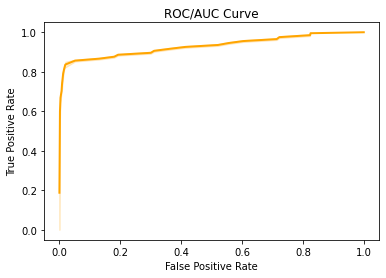

In [46]:
# plotting the ROC CURVE
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x = fpr, y = tpr, color= 'orange',lw = 2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC/AUC Curve')
#plt.savefig('roc curve')
plt.show()

C:\Users\charityg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


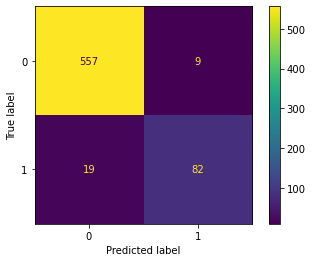

In [47]:
# confusion matrix
plot_confusion_matrix(xgb, new_X_test, y_test)
plt.grid(False)
#plt.savefig('matrix')
plt.show()


In [48]:
with open('xgb_model.pkl', 'wb') as f:
    joblib.dump(xgb, f)

### Conclusion

* From the models created, the XGBClassifier with default hyperparameters({'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 180}) was the best for precision.It is also doing really well in accuracy and also in recall
* Using the model, the features of the customer can predict whether  a customer will churn or not. Then the customers can be put into different groups and different marketing strategies can be used on them, one for retaining the customers who wont churn and another for holding onto the one who thinks of churning. Instead of wasting money on one marketing strategy for all
* Precision is key in this type of data, since the company should have a model that correctly predicts the probability of people not churning. If it is wrongly predicted that a customer stays when infact they are leaving, the rate of retention will be low, and getting new customers is more expensive than retaining the ones already there. So the model I have chosen caters for high overall accuracy and high precision